<a href="https://colab.research.google.com/github/zihxnw/Data-Bootcamp-Final-Project/blob/main/Zihan_%26_Aleesha_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install meteostat

In [ ]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from meteostat import Daily
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import seaborn as sns
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/forest fires/FPA_FOD_20221014.sqlite'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
conn = sqlite3.connect(path)
query = """
    SELECT FIRE_YEAR, DISCOVERY_DATE, DISCOVERY_TIME, LATITUDE, LONGITUDE, NWCG_GENERAL_CAUSE, STATE, FIRE_SIZE, FIRE_SIZE_CLASS
    FROM Fires
    """
df = pd.read_sql_query(query, conn)
conn.close()

In [ ]:
def get_region(row):
    state = row['STATE']
    #defining regions
    regionmap = {
        'CA': 'West',
        'OR': 'Northwest', 'WA': 'Northwest',
        'AZ': 'Southwest', 'NM': 'Southwest', 'TX': 'Southwest', 'OK': 'Southwest',
        'CO': 'Rockies', 'ID': 'Rockies', 'MT': 'Rockies',
        'WY': 'Rockies', 'UT': 'Rockies', 'NV': 'Rockies',
        'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest',
        'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'WI': 'Midwest',
        'IL': 'Midwest', 'MI': 'Midwest', 'IN': 'Midwest', 'OH': 'Midwest',
        'KY': 'Southeast', 'WV': 'Southeast', 'VA': 'Southeast', 'TN': 'Southeast',
        'NC': 'Southeast', 'SC': 'Southeast', 'GA': 'Southeast', 'AL': 'Southeast',
        'MS': 'Southeast', 'AR': 'Southeast', 'LA': 'Southeast', 'FL': 'Southeast',
        'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast', 'MA': 'Northeast',
        'RI': 'Northeast', 'CT': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast',
        'PA': 'Northeast', 'DE': 'Northeast', 'MD': 'Northeast', 'DC': 'Northeast'
    }
    return regionmap.get(state)

df['Region'] = df.apply(get_region, axis=1)

print(df['Region'].value_counts())

Region
Southeast    852292
Southwest    378810
West         251881
Rockies      239850
Midwest      236276
Northeast    184865
Northwest    112225
Name: count, dtype: int64


In [ ]:
station_map = {
    'West': '72483',
    'Southwest': '72278',
    'Northwest': '72698',
    'Rockies': '72469',
    'Midwest': '72530',
    'Southeast': '72219',
    'Northeast': '72503'
}

weather = []
#used airport codes to find weather for each region.
for region, station_id in station_map.items():
    data = Daily(station_id, start=datetime(1992, 1, 1), end=datetime(2020, 12, 31))
    data = data.fetch()
    weatherdf = data.reset_index()
    weatherdf['time'] = pd.to_datetime(weatherdf['time']).dt.normalize()
    weatherdf = weatherdf.rename(columns={'time': 'DISCOVERY_DATE'})
    weatherdf['Region'] = region
    weather.append(weatherdf[['DISCOVERY_DATE', 'Region', 'tmax', 'wspd']])
dfweather = pd.concat(weather)
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.normalize()
#merging dataframes together
df = df.merge(dfweather, on=['Region', 'DISCOVERY_DATE'], how='left')
(df[['DISCOVERY_DATE', 'Region', 'tmax', 'wspd']].head())

,DISCOVERY_DATE,Region,tmax,wspd
0,2005-02-02,West,16.1,4.7
1,2004-05-12,West,27.2,14.4
2,2004-05-31,West,33.9,6.1
3,2004-06-28,West,31.7,14.4
4,2004-06-28,West,31.7,14.4


In [ ]:
threshold = 10
df["DISCOVERY_DATE"] = pd.to_datetime(df["DISCOVERY_DATE"])
df["Month"] = df["DISCOVERY_DATE"].dt.month
df["is_severe"] = (df["FIRE_SIZE"] > threshold).astype(int)
df['DOW'] = df['DISCOVERY_DATE'].dt.dayofweek
df['DOY'] = df['DISCOVERY_DATE'].dt.dayofyear
df['Cause_Code'] = df['NWCG_GENERAL_CAUSE'].astype('category').cat.codes #assigned alphabetically!
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "FIRE_SIZE", "Month", "NWCG_GENERAL_CAUSE", 'tmax', 'wspd'])
df = df[df['NWCG_GENERAL_CAUSE'] != "Missing data/not specified/undetermined"]
#fire index is just combining temperature & wind speed
df['Fire_Index'] = df['tmax'] * df['wspd']

In [ ]:
df

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,LATITUDE,LONGITUDE,NWCG_GENERAL_CAUSE,STATE,FIRE_SIZE,FIRE_SIZE_CLASS,Region,tmax,wspd,Month,is_severe,DOW,DOY,Cause_Code,Fire_Index
0,2005,2005-02-02,1300,40.036944,-121.005833,Power generation/transmission/distribution,CA,0.10,A,West,16.1,4.7,2,0,2,33,9,75.67
1,2004,2004-05-12,0845,38.933056,-120.404444,Natural,CA,0.25,A,West,27.2,14.4,5,0,2,133,7,391.68
2,2004,2004-05-31,1921,38.984167,-120.735556,Debris and open burning,CA,0.10,A,West,33.9,6.1,5,0,0,152,1,206.79
3,2004,2004-06-28,1600,38.559167,-119.913333,Natural,CA,0.10,A,West,31.7,14.4,6,0,0,180,7,456.48
4,2004,2004-06-28,1600,38.559167,-119.933056,Natural,CA,0.10,A,West,31.7,14.4,6,0,0,180,7,456.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303550,2019,2019-07-01,1839,31.423040,-110.571000,Natural,AZ,438.00,E,Southwest,43.3,13.0,7,1,0,182,7,562.9
2303558,2019,2019-08-09,2134,44.285050,-118.459800,Natural,OR,9668.00,G,Northwest,25.0,9.7,8,1,4,221,7,242.5
2303561,2020,2020-06-05,1741,39.037890,-108.959500,Natural,CO,1.00,B,Rockies,33.5,13.5,6,0,4,157,7,452.25
2303563,2020,2020-08-27,1911,46.151370,-114.442800,Natural,MT,50.00,C,Rockies,33.4,11.0,8,1,3,240,7,367.4


In [ ]:
#balancing out the regions by making each region have the same amount of entries (# of entries of the region with the least!)
min_size = df['Region'].value_counts().min()
df = df.groupby('Region').apply(
    lambda x: x.sample(min_size, random_state=50)
).reset_index(drop=True)
print(df['Region'].value_counts())

Region
Midwest      34531
Northeast    34531
Northwest    34531
Rockies      34531
Southeast    34531
Southwest    34531
West         34531
Name: count, dtype: int64


XGB MODEL: location predictor


In [ ]:
X = pd.get_dummies(df[['Region', 'Month', 'LATITUDE', 'LONGITUDE', 'tmax', 'wspd']], columns=['Region']) #encoding
y = df['is_severe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
ratio = float(df['is_severe'].value_counts()[0]) / df['is_severe'].value_counts()[1] #ratio of not severe to is severe data

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.01, #slower learning rate to make sure our model is accurate
    scale_pos_weight=ratio, #balancing the data with the ratio found above
    random_state=50,
    use_label_encoder=False,
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

Parameters: { "use_label_encoder" } are not used.



              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43487
           1       0.21      0.64      0.31      4857

    accuracy                           0.72     48344
   macro avg       0.58      0.68      0.57     48344
weighted avg       0.87      0.72      0.77     48344



Decision Tree: At this Lat, Long, during (month) is the fire severe?

In [ ]:
#Comparing this model to the XGB model!
X4 = df[['LATITUDE', 'LONGITUDE', 'Month', 'tmax']]
y4 = df['is_severe']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=50)

tree_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=50, class_weight='balanced') #balancing our model with class_weight = 'balanced'
tree_model.fit(X_train4, y_train4)

y_pred4 = tree_model.predict(X_test4)
print(f"Tree Accuracy: {accuracy_score(y_test4, y_pred4)}")
print(classification_report(y_test4, y_pred4))

Tree Accuracy: 0.8059945391361907
              precision    recall  f1-score   support

           0       0.94      0.83      0.89     43487
           1       0.27      0.55      0.36      4857

    accuracy                           0.81     48344
   macro avg       0.61      0.69      0.62     48344
weighted avg       0.88      0.81      0.83     48344



CAUSE OF FIRE? XGB MODEL

In [ ]:
target_causes = [
    'Natural',
    'Arson/incendiarism',
    'Recreation and ceremony',
    'Debris and open burning'
]

In [ ]:
xgbmodel = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softprob', #used this instead of softmax because we needed confidence scores
    num_class=len(target_causes),
    n_jobs=-1
)
df = df[df['NWCG_GENERAL_CAUSE'].isin(target_causes)].copy()
X5 = df[['LATITUDE', 'LONGITUDE', 'Month', 'DOW', 'DOY', 'wspd', 'tmax']]
y5 = df['NWCG_GENERAL_CAUSE']
le = LabelEncoder()
y_encoded5 = le.fit_transform(y5)

X_train5, X_test5, y_train5, y_test5 = train_test_split(
X5, y_encoded5, test_size=0.2, random_state=50, stratify=y_encoded5) #stratify means splitting in respect the ratios we already have in the encoded version of y.

weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train5
)
xgbmodel.fit(
    X_train5,
    y_train5,
    sample_weight=weights
)
y_pred5 = xgbmodel.predict(X_test5)
target_names = le.inverse_transform(sorted(list(set(y_test5))))
print(classification_report(y_test5, y_pred5, target_names=target_names))

                         precision    recall  f1-score   support

     Arson/incendiarism       0.55      0.65      0.59      7481
Debris and open burning       0.74      0.61      0.67     11977
                Natural       0.83      0.79      0.81     11734
Recreation and ceremony       0.39      0.51      0.44      3838

               accuracy                           0.67     35030
              macro avg       0.63      0.64      0.63     35030
           weighted avg       0.69      0.67      0.67     35030



Neural Net (acres burned)

In [ ]:
df_new = df.dropna(subset=["tmax", "wspd", "FIRE_SIZE"])
df["FIRE_SIZE_LOG"] = np.log1p(df_new["FIRE_SIZE"]) #squishes the huge range into smaller numbers

In [ ]:
feature_col = ["LATITUDE", "LONGITUDE", "tmax", "wspd", "DOY", "Cause_Code", "STATE"]
target_col = "FIRE_SIZE"

In [ ]:
X = df_new[feature_col].copy()
y = df["FIRE_SIZE_LOG"]

X = pd.get_dummies(X, columns=["Cause_Code", "STATE"], drop_first=True) #converting into 0s and 1s

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values.astype(float))
X_test_scaled = scaler.transform(X_test.values.astype(float))

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=65, shuffle=True)

In [ ]:
input_dim = X_train_tensor.shape[1]
model = nn.Sequential(
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

In [ ]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
epochs = 150
for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()
  predictons = model(X_train_tensor)
  loss2 = loss(predictons, y_train_tensor)
  loss2.backward()
  optimizer.step()
  if (epoch+1) % 10 == 0:
    print(f"Epoch {epoch+1}/{epochs}, Loss:{loss2.item():.4f}")

Epoch 10/150, Loss:1.7772
Epoch 20/150, Loss:1.6431
Epoch 30/150, Loss:1.6183
Epoch 40/150, Loss:1.6082
Epoch 50/150, Loss:1.6016
Epoch 60/150, Loss:1.5958
Epoch 70/150, Loss:1.5909
Epoch 80/150, Loss:1.5867
Epoch 90/150, Loss:1.5829
Epoch 100/150, Loss:1.5795
Epoch 110/150, Loss:1.5766
Epoch 120/150, Loss:1.5737
Epoch 130/150, Loss:1.5706
Epoch 140/150, Loss:1.5674
Epoch 150/150, Loss:1.5641


In [ ]:
model.eval()
with torch.no_grad():
  test_preds = model(X_test_tensor)
  real_preds = torch.expm1(test_preds)
  real_actual = torch.expm1(y_test_tensor) #converting it back to real acres
  real_mae = torch.mean(torch.abs(real_preds - real_actual))

print(f"Average Error (Real World): {real_mae.item():.2f} acres")
mae = torch.mean(torch.abs(test_preds - y_test_tensor)) #calculate error on real acres
print(f"Average Error On Test Set: {mae.item():.2f} acres")

Average Error (Real World): 83.98 acres
Average Error On Test Set: 0.80 acres


In [ ]:
print(f"Example -> Predicted: {test_preds[0].item():.1f}, Actual: {y_test_tensor[0].item():.1f}")

Example -> Predicted: 0.6, Actual: 0.1


Logistic Regression - What is the probability that the cause was not natural?



In [ ]:
df_clean = df.dropna(subset=["tmax", "wspd", "Cause_Code"])
df_clean['Is_Human_Caused'] = df_clean['Cause_Code'].apply(lambda x: 1.0 if x != 1.0 else 0.0)

In [ ]:
features_new = ["LATITUDE", "LONGITUDE", "tmax", "wspd", "DOY", "STATE"]

In [ ]:
X = df_clean[features_new].copy()
y = df_clean["Is_Human_Caused"]

X = pd.get_dummies(X, columns=["STATE"], drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=48)

In [ ]:
Scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
log_preds = log_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, log_preds)

print(f"Logistic Accuracy: {accuracy*100:.2f}%")

print("SAMPLE PREDICTIONS")
for i in range(5):
    print(f"Prediction: {log_preds[i]} | Actual: {y_test.iloc[i]}")

Logistic Accuracy: 75.56%
SAMPLE PREDICTIONS
Prediction: 1.0 | Actual: 1.0
Prediction: 0.0 | Actual: 0.0
Prediction: 0.0 | Actual: 0.0
Prediction: 1.0 | Actual: 0.0
Prediction: 1.0 | Actual: 0.0


In [ ]:
print("Classification Report:")
print(classification_report(y_test, log_preds, target_names=["Natural", "Human"]))

Classification Report:
              precision    recall  f1-score   support

     Natural       0.67      0.56      0.61     11957
       Human       0.79      0.85      0.82     23073

    accuracy                           0.76     35030
   macro avg       0.73      0.71      0.72     35030
weighted avg       0.75      0.76      0.75     35030



KNN model - What is the probability that the cause was not natural?



In [ ]:
df_clean = df.dropna(subset=["tmax", "wspd", "Cause_Code", "STATE"]).copy()
df_clean['Is_Human'] = np.where(df_clean['Cause_Code'] != 1.0, 1.0, 0.0)

In [ ]:
feature_col3 = ['LATITUDE', 'LONGITUDE', 'tmax', 'wspd', 'DOY', 'STATE']
X = df_clean[feature_col3].copy()
y = df_clean['Is_Human']

X = pd.get_dummies(X, columns=["STATE"], drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=43)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print("Training KNN Model (Finding Neighbors)")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

Training KNN Model (Finding Neighbors)


KNeighborsClassifier()

In [ ]:
probs = knn_model.predict_proba(X_test_scaled)[:, 1]
knn_preds = (probs > 0.5).astype(int)
accuracy = accuracy_score(y_test, knn_preds)

print("SAMPLE NEIGHBOR ANALYSIS")
print("Goal: Probability this is NOT Natural (Human Caused)")
print(f"Total Accuracy: {accuracy*100:.2f}%")

for i in range(10):
    p = probs[i]

    actual = "Human" if y_test.iloc[i] == 1.0 else "Natural"

    print(f"Fire {i+1}: {p:.1%} Probability Human | Actual: {actual}") #putting it as a percentage

SAMPLE NEIGHBOR ANALYSIS
Goal: Probability this is NOT Natural (Human Caused)
Total Accuracy: 76.65%
Fire 1: 80.0% Probability Human | Actual: Human
Fire 2: 40.0% Probability Human | Actual: Natural
Fire 3: 0.0% Probability Human | Actual: Human
Fire 4: 80.0% Probability Human | Actual: Human
Fire 5: 100.0% Probability Human | Actual: Human
Fire 6: 20.0% Probability Human | Actual: Natural
Fire 7: 100.0% Probability Human | Actual: Human
Fire 8: 60.0% Probability Human | Actual: Natural
Fire 9: 100.0% Probability Human | Actual: Human
Fire 10: 80.0% Probability Human | Actual: Human


In [ ]:
print(classification_report(y_test, knn_preds, target_names=['Natural', 'Human']))

              precision    recall  f1-score   support

     Natural       0.67      0.63      0.65     12100
       Human       0.81      0.84      0.82     22930

    accuracy                           0.77     35030
   macro avg       0.74      0.73      0.74     35030
weighted avg       0.76      0.77      0.76     35030



Logistic Regression - In terms of wildfire severity, which regions are most sensitive to extreme weather conditions?

In [ ]:
west_mark = df["LONGITUDE"] < -100
east_mark = df["LONGITUDE"] >= -100

df_west = df[west_mark].copy()
df_east = df[east_mark].copy()

features = ["tmax", "wspd", "Month"]

X_west = df_west[features]
y_west = (df_west["FIRE_SIZE"] > 10).astype(int) #differentiating the severity of wildfires

X_east = df_east[features]
y_east = (df_east["FIRE_SIZE"] > 10).astype(int)

model = LogisticRegression(class_weight='balanced', random_state=45)

model.fit(X_west, y_west)
west_heat = model.coef_[0][0]
west_wind = model.coef_[0][1]


model.fit(X_east, y_east)
east_heat = model.coef_[0][0]
east_wind = model.coef_[0][1]


print(f"{'FEATURE':<10}  {'WEST SCORE':<12}  {'EAST SCORE':<12}")
print(f"{'Heat':<10}     {west_heat:.2f}          {east_heat:.2f}")
print(f"{'Wind':<10}     {west_wind:.2f}         {east_wind:.2f}")

FEATURE     WEST SCORE    EAST SCORE  
Heat           0.02          0.00
Wind           0.03         -0.03


Visualization #1: Heatmap

In [ ]:
mapdf = df[["LATITUDE", 'LONGITUDE']]
sample_size = 150000
dfmap = mapdf.sample(n=sample_size, random_state=50)
map = folium.Map(location=[40.729675, -73.996925], zoom_start=4)

map = folium.Map(
    location=[40.729675, -73.996925],
    zoom_start=4,
    tiles='OpenStreetMap'
)

heatmap = dfmap[['LATITUDE', 'LONGITUDE']].values.tolist()

HeatMap(
    heatmap,
    radius=11,
    blur=15,
    min_opacity=0.4,
    gradient={0.2: 'blue', 0.4: 'green', 0.6: 'orange', 1: 'red'}
).add_to(map)

map

Visualization #2: Correlation Map

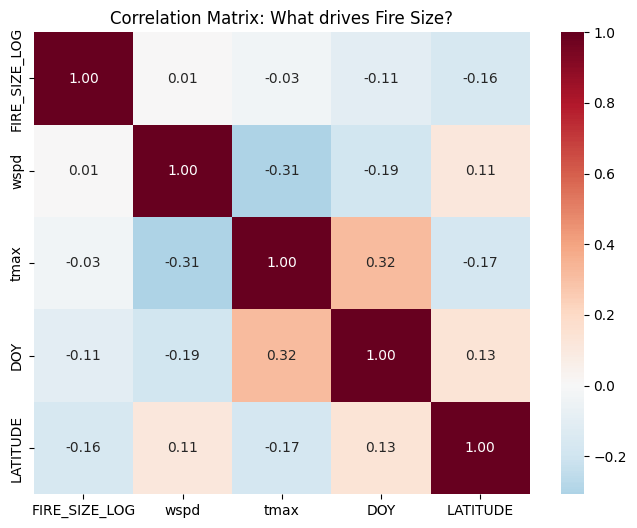

In [ ]:
df_new["FIRE_SIZE_LOG"] = np.log1p(df_new["FIRE_SIZE"])

cols = ["FIRE_SIZE_LOG", "wspd", "tmax", "DOY", "LATITUDE"]
corr = df_new[cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr,
            annot=True,
            cmap="RdBu_r",
            center=0,
            fmt=".2f")
plt.title("Correlation Matrix: What drives Fire Size?")
plt.show()